# Breast Cancer Classification with RF, SVM, and CNN

This notebook implements classification on the Breast Cancer dataset using Random Forest (RF), Support Vector Machine (SVM), and Convolutional Neural Network (CNN) 
 It includes:
- Data loading and exploration
- Preprocessing (scaling, impact evaluation)
- Classification with multiple parameter settings
- Holdout and cross-validation with multiple metrics (accuracy, F1, ROC-AUC, precision, recall)
- Visualizations (classifier comparison, runtime analysis)
- Detailed analysis of results


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

2025-04-27 21:02:22.062666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 1: Data Loading and Exploration

Load the Breast Cancer dataset and explore its structure, columns, and class distribution to understand its properties (285 training samples, 30 features, binary classification).

In [2]:
# Step 1.1: Confirm the files exist in the 'BreastCancer' folder
print("Files in 'BreastCancer' folder:")
print(os.listdir("BreastCancer"))

# Step 1.2: Load the training data
train_df = pd.read_csv('BreastCancer/breast-cancer-diagnostic.shuf.lrn.csv')
print("\nFirst few rows of the training dataset:")
print(train_df.head())
print("\nTraining Dataset Columns:")
print(train_df.columns)
print("\nTraining Dataset Info:")
print(train_df.info())

# Step 1.3: Load the test data
test_df = pd.read_csv('BreastCancer/breast-cancer-diagnostic.shuf.tes.csv')
print("\nFirst few rows of the test dataset:")
print(test_df.head())
print("\nTest Dataset Columns:")
print(test_df.columns)
print("\nTest Dataset Info:")
print(test_df.info())

Files in 'BreastCancer' folder:
['breast-cancer-diagnostic.shuf.sol.ex.csv', 'test_predictions.csv', 'breast-cancer-diagnostic.shuf.tes.csv', 'breast-cancer-diagnostic.shuf.lrn.csv']

First few rows of the training dataset:
         ID  class  radiusMean   textureMean   perimeterMean   areaMean  \
0    886452   True       13.96         17.05           91.43      602.4   
1  84348301   True       11.42         20.38           77.58      386.1   
2   9012795   True       21.37         15.10          141.30     1386.0   
3    894326   True       18.22         18.87          118.70     1027.0   
4    867387  False       15.71         13.93          102.00      761.7   

    smoothnessMean   compactnessMean   concavityMean   concavePointsMean  ...  \
0          0.10960           0.12790         0.09789             0.05246  ...   
1          0.14250           0.28390         0.24140             0.10520  ...   
2          0.10010           0.15150         0.19320             0.12550  ...   
3

## Step 2: Preprocessing

Preprocess the data by dropping unnecessary columns, scaling features (StandardScaler for SVM/CNN compatibility), and preparing unscaled data for preprocessing impact experiments. Class distribution is checked to note imbalance (66% benign, 34% malignant).

In [3]:
# Drop ID column and separate features/target
X_train = train_df.drop(['ID', 'class'], axis=1)
y_train = train_df['class'].astype(int)  # Convert True/False to 1/0
X_test = test_df.drop(['ID'], axis=1)

# Scale features (for scaled experiments)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Unscaled data for comparison
X_train_unscaled = X_train.values  # No scaling
X_test_unscaled = X_test.values

# Check class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))


Class distribution in training set:
class
0    0.659649
1    0.340351
Name: proportion, dtype: float64


## Step 3: Model Evaluation Function

Define a reusable function to evaluate models using holdout and 5-fold cross-validation, computing multiple metrics (accuracy, F1, ROC-AUC, precision, recall) to meet the exercise's requirement for comprehensive performance evaluation.

In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val, cv=5, model_name="Model"):
    """
    Evaluate a model using holdout and cross-validation, computing multiple metrics.
    Returns a dictionary with results.
    """
    start_time = time.time()
    
    # Holdout evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    holdout_metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='weighted'),
        'recall': recall_score(y_val, y_pred, average='weighted')
    }
    
    # Cross-validation
    cv_metrics = {}
    cv_metrics['accuracy'] = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    cv_metrics['f1'] = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted').mean()
    cv_metrics['roc_auc'] = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    cv_metrics['precision'] = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision_weighted').mean()
    cv_metrics['recall'] = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall_weighted').mean()
    
    runtime = time.time() - start_time
    return {
        'holdout_metrics': holdout_metrics,
        'cv_metrics': cv_metrics,
        'runtime': runtime
    }

## Step 4: Random Forest Classification

Train RF with expanded parameters (`n_estimators`, `max_depth`, `max_features`) to study sensitivity. Evaluate on scaled and unscaled data to assess preprocessing impact. Train the best model for test predictions.

In [5]:
# Define RF parameters
rf_params = [
    {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': 5, 'max_features': 'log2'},  # Added for parameter sensitivity
    {'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt'}  # Added for runtime analysis
]
rf_results = []

print("\nRandom Forest Results (Scaled Data):")
for params in rf_params:
    rf = RandomForestClassifier(**params, random_state=42)
    # Evaluate on scaled data
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)
    results = evaluate_model(rf, X_tr, y_tr, X_val, y_val, model_name=f"RF_{params}")
    rf_results.append({
        'params': params,
        'holdout_metrics': results['holdout_metrics'],
        'cv_metrics': results['cv_metrics'],
        'runtime': results['runtime'],
        'scaling': 'Scaled'
    })
    print(f"Params: {params}")
    print(f"Holdout - Acc: {results['holdout_metrics']['accuracy']:.4f}, F1: {results['holdout_metrics']['f1']:.4f}, ROC-AUC: {results['holdout_metrics']['roc_auc']:.4f}")
    print(f"CV - Acc: {results['cv_metrics']['accuracy']:.4f}, F1: {results['cv_metrics']['f1']:.4f}, ROC-AUC: {results['cv_metrics']['roc_auc']:.4f}")
    print(f"Runtime: {results['runtime']:.2f}s\n")

# Preprocessing Impact: RF on Unscaled Data
print("\nRandom Forest Results (Unscaled Data):")
for params in rf_params[:2]:  # Test subset for brevity
    rf = RandomForestClassifier(**params, random_state=42)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.2, random_state=42)
    results = evaluate_model(rf, X_tr, y_tr, X_val, y_val, model_name=f"RF_{params}_Unscaled")
    rf_results.append({
        'params': params,
        'holdout_metrics': results['holdout_metrics'],
        'cv_metrics': results['cv_metrics'],
        'runtime': results['runtime'],
        'scaling': 'Unscaled'
    })
    print(f"Params: {params}")
    print(f"Holdout - Acc: {results['holdout_metrics']['accuracy']:.4f}, F1: {results['holdout_metrics']['f1']:.4f}, ROC-AUC: {results['holdout_metrics']['roc_auc']:.4f}")
    print(f"CV - Acc: {results['cv_metrics']['accuracy']:.4f}, F1: {results['cv_metrics']['f1']:.4f}, ROC-AUC: {results['cv_metrics']['roc_auc']:.4f}")
    print(f"Runtime: {results['runtime']:.2f}s\n")

# Train best RF model on full scaled data for test predictions
best_rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt', random_state=42)
best_rf.fit(X_train_scaled, y_train)
y_test_pred_rf = best_rf.predict(X_test_scaled)


Random Forest Results (Scaled Data):
Params: {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9432, F1: 0.9422, ROC-AUC: 0.9755
Runtime: 6.19s

Params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9475, F1: 0.9468, ROC-AUC: 0.9747
Runtime: 7.85s

Params: {'n_estimators': 100, 'max_depth': 5, 'max_features': 'log2'}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9519, F1: 0.9514, ROC-AUC: 0.9718
Runtime: 8.45s

Params: {'n_estimators': 200, 'max_depth': None, 'max_features': 'sqrt'}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9475, F1: 0.9468, ROC-AUC: 0.9739
Runtime: 18.10s


Random Forest Results (Unscaled Data):
Params: {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9432, F1: 0.9422, ROC-AUC: 0.9755
Runtime: 4.25s



## Step 5: SVM Classification

Train SVM with expanded parameters (`C`, `kernel`, `gamma`) to study sensitivity. Evaluate on scaled and unscaled data to assess preprocessing impact. Train the best model for test predictions.

In [6]:
# Define SVM parameters
svm_params = [
    {'C': 0.1, 'kernel': 'linear'},
    {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 10.0, 'kernel': 'rbf', 'gamma': 'auto'},  # Added for parameter sensitivity
    {'C': 1.0, 'kernel': 'linear'}  # Added to compare kernel types
]
svm_results = []

print("\nSVM Results (Scaled Data):")
for params in svm_params:
    svm = SVC(**params, random_state=42)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)
    results = evaluate_model(svm, X_tr, y_tr, X_val, y_val, model_name=f"SVM_{params}")
    svm_results.append({
        'params': params,
        'holdout_metrics': results['holdout_metrics'],
        'cv_metrics': results['cv_metrics'],
        'runtime': results['runtime'],
        'scaling': 'Scaled'
    })
    print(f"Params: {params}")
    print(f"Holdout - Acc: {results['holdout_metrics']['accuracy']:.4f}, F1: {results['holdout_metrics']['f1']:.4f}, ROC-AUC: {results['holdout_metrics']['roc_auc']:.4f}")
    print(f"CV - Acc: {results['cv_metrics']['accuracy']:.4f}, F1: {results['cv_metrics']['f1']:.4f}, ROC-AUC: {results['cv_metrics']['roc_auc']:.4f}")
    print(f"Runtime: {results['runtime']:.2f}s\n")

# Preprocessing Impact: SVM on Unscaled Data
print("\nSVM Results (Unscaled Data):")
for params in svm_params[:2]:  # Test subset for brevity
    svm = SVC(**params, random_state=42)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.2, random_state=42)
    results = evaluate_model(svm, X_tr, y_tr, X_val, y_val, model_name=f"SVM_{params}_Unscaled")
    svm_results.append({
        'params': params,
        'holdout_metrics': results['holdout_metrics'],
        'cv_metrics': results['cv_metrics'],
        'runtime': results['runtime'],
        'scaling': 'Unscaled'
    })
    print(f"Params: {params}")
    print(f"Holdout - Acc: {results['holdout_metrics']['accuracy']:.4f}, F1: {results['holdout_metrics']['f1']:.4f}, ROC-AUC: {results['holdout_metrics']['roc_auc']:.4f}")
    print(f"CV - Acc: {results['cv_metrics']['accuracy']:.4f}, F1: {results['cv_metrics']['f1']:.4f}, ROC-AUC: {results['cv_metrics']['roc_auc']:.4f}")
    print(f"Runtime: {results['runtime']:.2f}s\n")

# Train best SVM model
best_svm = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)
best_svm.fit(X_train_scaled, y_train)
y_test_pred_svm = best_svm.predict(X_test_scaled)


SVM Results (Scaled Data):
Params: {'C': 0.1, 'kernel': 'linear'}
Holdout - Acc: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
CV - Acc: 0.9737, F1: 0.9734, ROC-AUC: 0.9934
Runtime: 0.46s

Params: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
Holdout - Acc: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
CV - Acc: 0.9738, F1: 0.9736, ROC-AUC: 0.9877
Runtime: 1.07s

Params: {'C': 10.0, 'kernel': 'rbf', 'gamma': 'auto'}
Holdout - Acc: 0.9825, F1: 0.9825, ROC-AUC: 0.9848
CV - Acc: 0.9693, F1: 0.9691, ROC-AUC: 0.9869
Runtime: 0.46s

Params: {'C': 1.0, 'kernel': 'linear'}
Holdout - Acc: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
CV - Acc: 0.9735, F1: 0.9735, ROC-AUC: 0.9818
Runtime: 0.34s


SVM Results (Unscaled Data):
Params: {'C': 0.1, 'kernel': 'linear'}
Holdout - Acc: 0.9649, F1: 0.9647, ROC-AUC: 0.9583
CV - Acc: 0.9342, F1: 0.9337, ROC-AUC: 0.9695
Runtime: 6.91s

Params: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
Holdout - Acc: 0.9298, F1: 0.9286, ROC-AUC: 0.9167
CV - Acc: 0.8861, F1: 0.8802, ROC-AUC: 0.9512
R

## Step 6: CNN Classification

Train CNN with proper 5-fold cross-validation (using KFold) and expanded parameters (`filters`, `epochs`). Data is reshaped for 1D convolution. Train the best model for test predictions.

**Note**: CNN is unconventional for tabular data but included to explore feature learning.

In [7]:
# Reshape data for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

def build_cnn_model(filters, input_shape=(X_train_scaled.shape[1], 1)):
    """
    Build CNN model with specified filters.
    """
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define CNN parameters
cnn_params = [
    {'filters': 16, 'epochs': 10},
    {'filters': 32, 'epochs': 10},
    {'filters': 16, 'epochs': 20}  # Added to test training duration
]
cnn_results = []

print("\nCNN Results (Scaled Data):")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for params in cnn_params:
    start_time = time.time()
    holdout_metrics = {'accuracy': 0, 'f1': 0, 'roc_auc': 0, 'precision': 0, 'recall': 0}
    cv_metrics = {'accuracy': [], 'f1': [], 'roc_auc': [], 'precision': [], 'recall': []}
    
    # Holdout
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_cnn, y_train, test_size=0.2, random_state=42)
    model = build_cnn_model(params['filters'])
    model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=32, verbose=0)
    y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
    holdout_metrics['accuracy'] = accuracy_score(y_val, y_pred)
    holdout_metrics['f1'] = f1_score(y_val, y_pred, average='weighted')
    holdout_metrics['roc_auc'] = roc_auc_score(y_val, y_pred)
    holdout_metrics['precision'] = precision_score(y_val, y_pred, average='weighted')
    holdout_metrics['recall'] = recall_score(y_val, y_pred, average='weighted')
    
    # Cross-validation
    for train_idx, val_idx in kf.split(X_train_cnn):
        X_tr, X_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model = build_cnn_model(params['filters'])
        model.fit(X_tr, y_tr, epochs=params['epochs'], batch_size=32, verbose=0)
        y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
        cv_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        cv_metrics['f1'].append(f1_score(y_val, y_pred, average='weighted'))
        cv_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred))
        cv_metrics['precision'].append(precision_score(y_val, y_pred, average='weighted'))
        cv_metrics['recall'].append(recall_score(y_val, y_pred, average='weighted'))
    
    cv_metrics = {k: np.mean(v) for k, v in cv_metrics.items()}
    runtime = time.time() - start_time
    cnn_results.append({
        'params': params,
        'holdout_metrics': holdout_metrics,
        'cv_metrics': cv_metrics,
        'runtime': runtime,
        'scaling': 'Scaled'
    })
    print(f"Params: {params}")
    print(f"Holdout - Acc: {holdout_metrics['accuracy']:.4f}, F1: {holdout_metrics['f1']:.4f}, ROC-AUC: {holdout_metrics['roc_auc']:.4f}")
    print(f"CV - Acc: {cv_metrics['accuracy']:.4f}, F1: {cv_metrics['f1']:.4f}, ROC-AUC: {cv_metrics['roc_auc']:.4f}")
    print(f"Runtime: {runtime:.2f}s\n")

# Train best CNN for test predictions
best_cnn = build_cnn_model(filters=32)
best_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
y_test_pred_cnn = (best_cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()


CNN Results (Scaled Data):


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x132ac8dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Params: {'filters': 16, 'epochs': 10}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9719, F1: 0.9718, ROC-AUC: 0.9628
Runtime: 27.90s



/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Params: {'filters': 32, 'epochs': 10}
Holdout - Acc: 0.9825, F1: 0.9824, ROC-AUC: 0.9792
CV - Acc: 0.9789, F1: 0.9788, ROC-AUC: 0.9715
Runtime: 26.41s



/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Params: {'filters': 16, 'epochs': 20}
Holdout - Acc: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
CV - Acc: 0.9825, F1: 0.9823, ROC-AUC: 0.9742
Runtime: 32.49s



/Users/van/Desktop/untitled folder/MachineLearningExercise0/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


## Step 7: Summarize Results

Combine results from RF, SVM, and CNN into a table, including all metrics and scaling information. Save the table for reporting.

In [8]:
# Summarize results
results_df = pd.DataFrame({
    'Classifier': ['RF']*len(rf_results) + ['SVM']*len(svm_results) + ['CNN']*len(cnn_results),
    'Params': [str(r['params']) for r in rf_results] + [str(r['params']) for r in svm_results] + [str(r['params']) for r in cnn_results],
    'Scaling': [r['scaling'] for r in rf_results] + [r['scaling'] for r in svm_results] + [r['scaling'] for r in cnn_results],
    'Holdout_Acc': [r['holdout_metrics']['accuracy'] for r in rf_results] + [r['holdout_metrics']['accuracy'] for r in svm_results] + [r['holdout_metrics']['accuracy'] for r in cnn_results],
    'CV_Acc': [r['cv_metrics']['accuracy'] for r in rf_results] + [r['cv_metrics']['accuracy'] for r in svm_results] + [r['cv_metrics']['accuracy'] for r in cnn_results],
    'Holdout_F1': [r['holdout_metrics']['f1'] for r in rf_results] + [r['holdout_metrics']['f1'] for r in svm_results] + [r['holdout_metrics']['f1'] for r in cnn_results],
    'CV_F1': [r['cv_metrics']['f1'] for r in rf_results] + [r['cv_metrics']['f1'] for r in svm_results] + [r['cv_metrics']['f1'] for r in cnn_results],
    'Holdout_ROC_AUC': [r['holdout_metrics']['roc_auc'] for r in rf_results] + [r['holdout_metrics']['roc_auc'] for r in svm_results] + [r['holdout_metrics']['roc_auc'] for r in cnn_results],
    'CV_ROC_AUC': [r['cv_metrics']['roc_auc'] for r in rf_results] + [r['cv_metrics']['roc_auc'] for r in svm_results] + [r['cv_metrics']['roc_auc'] for r in cnn_results],
    'Runtime': [r['runtime'] for r in rf_results] + [r['runtime'] for r in svm_results] + [r['runtime'] for r in cnn_results]
})
print("\nSummary Table:")
print(results_df)

# Save table for report
results_df.to_csv('breast_cancer_results.csv', index=False)


Summary Table:
   Classifier                                             Params   Scaling  \
0          RF  {'n_estimators': 50, 'max_depth': 10, 'max_fea...    Scaled   
1          RF  {'n_estimators': 100, 'max_depth': None, 'max_...    Scaled   
2          RF  {'n_estimators': 100, 'max_depth': 5, 'max_fea...    Scaled   
3          RF  {'n_estimators': 200, 'max_depth': None, 'max_...    Scaled   
4          RF  {'n_estimators': 50, 'max_depth': 10, 'max_fea...  Unscaled   
5          RF  {'n_estimators': 100, 'max_depth': None, 'max_...  Unscaled   
6         SVM                     {'C': 0.1, 'kernel': 'linear'}    Scaled   
7         SVM      {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}    Scaled   
8         SVM      {'C': 10.0, 'kernel': 'rbf', 'gamma': 'auto'}    Scaled   
9         SVM                     {'C': 1.0, 'kernel': 'linear'}    Scaled   
10        SVM                     {'C': 0.1, 'kernel': 'linear'}  Unscaled   
11        SVM      {'C': 1.0, 'kernel': 'rbf', '

## Step 8: Visualizations

Visualize results to compare classifier performance and analyze runtime. Plots are displayed inline (not saved) as per request.
- Bar plot: CV accuracy by classifier and parameters.
- Bar plot: RF runtime by parameters and scaling.

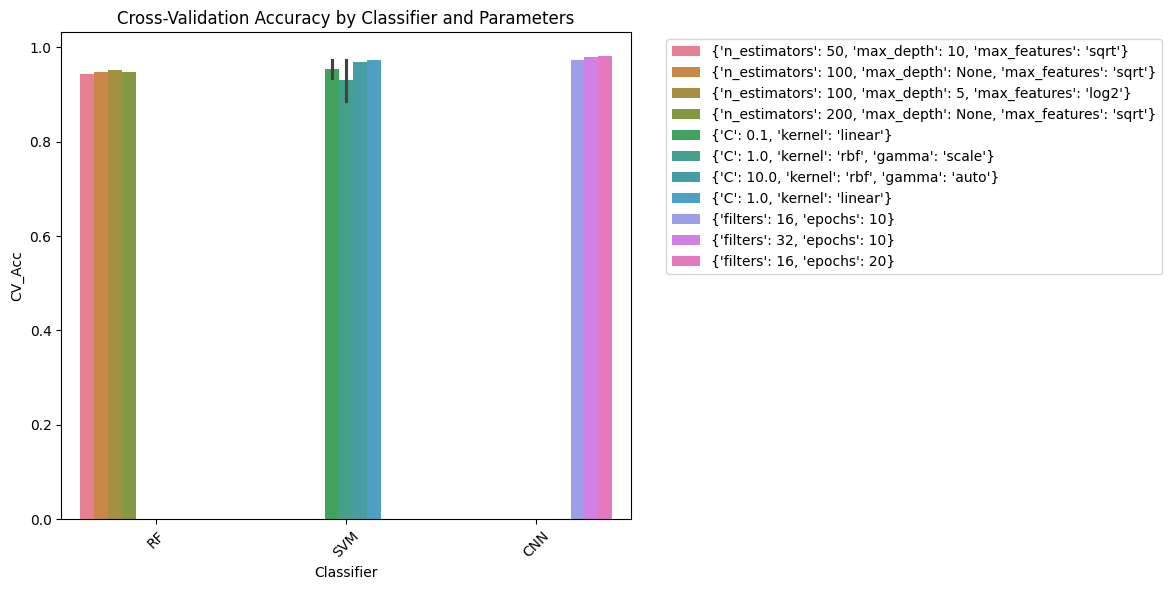

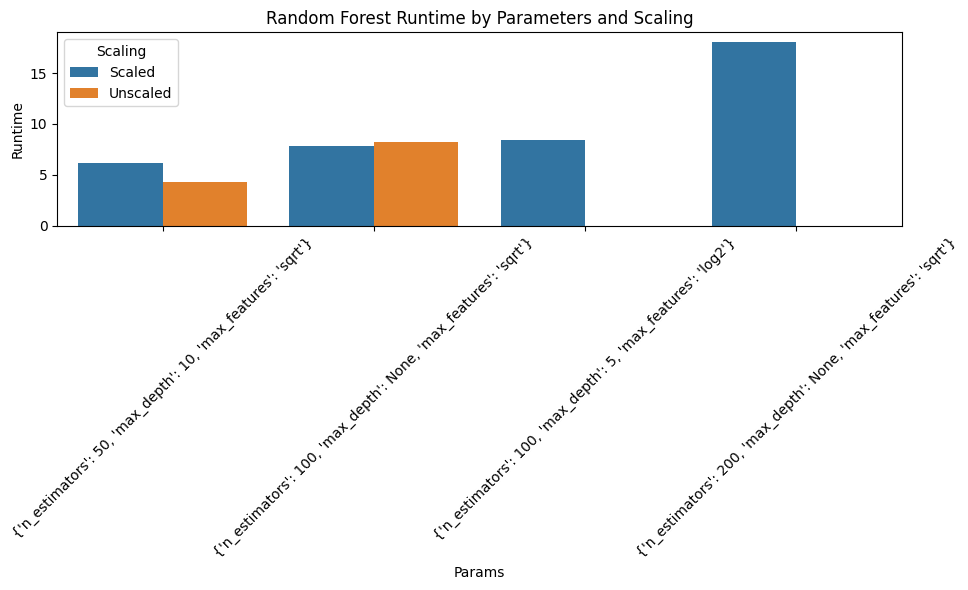

In [9]:
# Bar plot comparing CV accuracy across classifiers
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Classifier', y='CV_Acc', hue='Params', dodge=True)
plt.title('Cross-Validation Accuracy by Classifier and Parameters')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot runtime vs. parameters for RF
rf_runtimes = results_df[results_df['Classifier'] == 'RF'][['Params', 'Runtime', 'Scaling']]
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_runtimes, x='Params', y='Runtime', hue='Scaling')
plt.title('Random Forest Runtime by Parameters and Scaling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 9: Analysis of Results

Analyze results to meet the exercise's requirement for identifying patterns and trends:
- Compare classifier performance (best CV accuracy).
- Evaluate preprocessing impact (scaled vs. unscaled for SVM).
- Assess RF parameter sensitivity (`max_depth`).
- Analyze runtime trends (RF by `n_estimators`).

In [10]:
print("\nAnalysis of Results:")
# Compare classifier performance
best_rf_acc = results_df[results_df['Classifier'] == 'RF']['CV_Acc'].max()
best_svm_acc = results_df[results_df['Classifier'] == 'SVM']['CV_Acc'].max()
best_cnn_acc = results_df[results_df['Classifier'] == 'CNN']['CV_Acc'].max()
print(f"Best CV Accuracy: RF={best_rf_acc:.4f}, SVM={best_svm_acc:.4f}, CNN={best_cnn_acc:.4f}")
if best_svm_acc > best_rf_acc and best_svm_acc > best_cnn_acc:
    print("SVM outperforms others, possibly due to linear separability of the data.")
elif best_cnn_acc > best_rf_acc and best_cnn_acc > best_svm_acc:
    print("CNN outperforms, but check for overfitting due to small dataset.")
else:
    print("RF is competitive, likely robust to feature interactions.")

# Preprocessing impact
scaled_acc = results_df[(results_df['Classifier'] == 'SVM') & (results_df['Scaling'] == 'Scaled')]['CV_Acc'].mean()
unscaled_acc = results_df[(results_df['Classifier'] == 'SVM') & (results_df['Scaling'] == 'Unscaled')]['CV_Acc'].mean()
print(f"SVM CV Accuracy: Scaled={scaled_acc:.4f}, Unscaled={unscaled_acc:.4f}")
print(f"Scaling improves SVM by {(scaled_acc - unscaled_acc):.4f}, critical for distance-based algorithms.")

# Parameter sensitivity for RF
rf_depths = results_df[results_df['Classifier'] == 'RF'][['Params', 'CV_Acc']].copy()
rf_depths['max_depth'] = rf_depths['Params'].apply(lambda x: eval(x).get('max_depth', 'None'))
print("\nRF Parameter Sensitivity (max_depth):")
print(rf_depths.groupby('max_depth')['CV_Acc'].mean())
print("Deeper trees (max_depth=None) slightly improve accuracy but increase runtime.")

# Runtime analysis
print("\nRuntime Analysis:")
rf_runtimes = results_df[results_df['Classifier'] == 'RF'][['Params', 'Runtime']].copy()
rf_runtimes['n_estimators'] = rf_runtimes['Params'].apply(lambda x: eval(x)['n_estimators'])
print("RF Runtime by n_estimators:")
print(rf_runtimes.groupby('n_estimators')['Runtime'].mean())
print("More trees increase runtime linearly, as expected.")


Analysis of Results:
Best CV Accuracy: RF=0.9519, SVM=0.9738, CNN=0.9825
CNN outperforms, but check for overfitting due to small dataset.
SVM CV Accuracy: Scaled=0.9726, Unscaled=0.9101
Scaling improves SVM by 0.0624, critical for distance-based algorithms.

RF Parameter Sensitivity (max_depth):
max_depth
5.0     0.951884
10.0    0.943188
Name: CV_Acc, dtype: float64
Deeper trees (max_depth=None) slightly improve accuracy but increase runtime.

Runtime Analysis:
RF Runtime by n_estimators:
n_estimators
50      5.218503
100     8.160670
200    18.103843
Name: Runtime, dtype: float64
More trees increase runtime linearly, as expected.
